In [2]:
"""This top cell serves 2 main purposes: 
        1) set up classes and basic functions
        2) reads in a xlsx file taken from the csv format by HiTek
            
    Things to ask for when doing this analysis are:
        1) An excel spreadsheet from the csv output from HiTek
        2) An excel spreadsheet of swimmers where the cells are organized:
            Name -- Sex -- Training Group -- last two digits of freshman year (beginning of the season)"""

import numpy as np
import pandas as pd
import sklearn as sk
from sklearn import preprocessing
from sklearn import decomposition
from sklearn import cluster
from sklearn import ensemble
import seaborn as sns
import datetime
import time
import matplotlib.pyplot as plt
from sklearn import linear_model

event_list = ["50 Free", "100 Free","200 Free","500 Free", "1650 Free", "100 Back","200 Back","100 Breast", "200 Breast", "100 Fly", "200 Fly", "200 IM", "400 IM"]

#Basic Functions Needed
def plotter(x,y,title,color, prediction, regression,marker = 'o', ylabel = "Percent Improvement from First Swim"):
    plt.scatter(x, y, color=color)
    plt.title(title)
    plt.plot(x, prediction, 'b-', linewidth=3, fillstyle = 'none')
    plt.xlabel("Date (normalized)")
    plt.ylabel(ylabel)
    print('Coefficient of Linear Regression for the {0}: '.format(title), regression)
    plt.show()

def date_change(word):
    """converts the date from MMM-DD-YYYY format into a decimal where it is YY.MD so that we can adjust and normalize
    need to write a converter from MMM-DD-YYY after the word[3] == - line to floating points"""
    if isinstance(word, float):
        return word
    else:
        working_string = str(word)
        adjusted_date = 0
        #following is for MMM-DD-YYYY format
        if working_string[3] == "-":
            adjusted_date += int(working_string[9:])
            if working_string[:3] == "Oct":
                adjusted_date = float(adjusted_date)
            if working_string[:3] == "Nov":
                adjusted_date = float(adjusted_date) + 0.2
            if working_string[:3] == "Dec":
                adjusted_date = float(adjusted_date) + 0.4
            if working_string[:3] == "Jan":
                adjusted_date = float(adjusted_date) - 0.4
            if working_string[:3] == "Feb":
                adjusted_date = float(adjusted_date) - 0.2
            adjusted_date = adjusted_date + float(working_string[4:5])*.66
        
        #following is for #yyyy-mm-dd format
        if working_string[4] == "-":
            adjusted_date += int(working_string[2:4])
            if working_string[5:7] == "10":
                adjusted_date = float(adjusted_date)
            if working_string[5:7] == "11":
                adjusted_date = float(adjusted_date) + 0.2
            if working_string[5:7] == "12":
                adjusted_date = float(adjusted_date) + 0.4
            if working_string[5:7] == "01":
                adjusted_date = float(adjusted_date) - 0.4
            if working_string[5:7] == "02":
                adjusted_date = float(adjusted_date) - 0.2
            adjusted_date = adjusted_date + float(working_string[8:10])*.015
    return adjusted_date
  
def time_change(cell):
    """converts the time from the excel spreadsheet into a floating point"""
    """Checked"""
    if isinstance(cell, float):
        return cell
    if isinstance(cell, int):
        return float(cell)
    else:
        word = str(cell)
        if word[0] == "x":
            if word[2] != ":":
                return float(word[1:])
        
        if word[0] == "1":
            adjusted_time = 60*int(word[:1])+float(word[3:])
            return adjusted_time
        if word[2] ==":":
            if word[0] == " " or word[0] == "x":
                if word[2] == ":":
                    adjusted_time = 60*int(word[1])+float(word[3:])
                    return adjusted_time
                adjusted_time = word[1:]
            elif word[0] == "0":
                adjusted_time = 600*int(word[3])+60*int(word[4])+float(word[6:])
            return adjusted_time
        return float(word)
    
def percent(first_swim,current_swim):
    numerator = first_swim-current_swim
    denominator = 0 - first_swim
    return 100*numerator/denominator

def average(input_list):
    value = 0
    for item in input_list:
        value = value + item
    denominator = len(input_list)
    average = value/denominator
    return average

#Class Setup Section
class Swimmer():
    """ creates an object that will have attributes name, sex, training group, empty list of swims"""   
    def __init__(self, name, sex, trainingGroup, yearConverter):
        self.name = name
        self.sex = sex
        self.training_group = trainingGroup
        self.swims = []
        self.normalized_swims = []
        self.raw_drops = []
        self.year_conversion = yearConverter
        self.top_4_events = []
    
    def get_sex(self):
        return self.sex
    
    def get_training_group(self):
        return self.trainingGroup
    
    def add_swim(self, swim):
        """ adds swim objects to the list
        Checked"""
        self.swims.append(swim)
    
    def add_normalized_swim(self, swim):
        self.normalized_swims.append(swim)
    
    def __str__(self):
        """Checked"""
        return "Swimmer {0} is a {1} who trained with the {2} group".format(self.name, self.sex, self.trainingGroup)
    
    def recall_main_event(self):
        list_of_events = []
        for event in event_list:
            counter = 0
            for item in self.swims:
                if item.event == event:
                    counter = counter + 1
            event_tuple = event, counter
            list_of_events.append(event_tuple)
        main_event = list_of_events[0]
        for i in range(len(list_of_events)):
            if list_of_events[i][1] > main_event[1]:
                main_event = list_of_events[i]
        return main_event[0]
    
    def top4(self):
        #deletes all of the swims from a swimmers swims list that arent in their top 4 events
        list_of_events = []
        top_events = []
        top_4 = []
        for event in event_list:
            counter = 0
            for item in self.swims:
                if item.event == event:
                    counter = counter + 1
            event_tuple = event, counter
            list_of_events.append(event_tuple)
        for i in range(50,0,-1):
            for item in list_of_events:
                if item[1] == i:
                    top_events.append(item)
        for i in range(4):
            if top_events[i][1] >= 4:
                top_4.append(top_events[i][0])
                self.top_4_events.append(top_events[i][0])
        top4_events_only = []
        for swim in self.swims:
            if swim.event in top_4:
                top4_events_only.append(swim)
        self.swims = top4_events_only
    
    def recall_by_event(self, event):
        """returns a list of swims from the event passed to the method
            Checked"""
        recall_list = []
        for item in self.swims:
            if item.event == event:
                recall_list.append(item)
            else:
                pass
        return recall_list
    
    def recall_best_by_event(self, event):
        """returns the swimmer's fastest swim in the event given
        Checked"""
        working_list = []
        time = 999999.99
        for item in self.swims:
            if item.event == event:
                if item.time < time:
                    time = item.time
                    working_list.append(item)
        if working_list != []:
            best_swim = working_list[len(working_list)-1]
        return best_swim
    
    def recall_best_by_year_and_event(self, event):
        """returns a list of a swimmers season best swims, chronologically by season"""
        """Checked"""
        recall_list = []
        working_list = []
        for i in range(1,20):
            time = 9999.99
            for item in self.swims:
                if item.event == event:
                    if item.date > i and item.date < i+1:
                        if item.time < time:
                            time = item.time
                            working_list.append(item)
                        else:
                            pass
                    else:
                        pass
            if working_list != []:
                recall_list.append(working_list[len(working_list)-1])
                working_list.clear()
        return recall_list
    
    def recall_by_event_normalized(self, event):
        """Returns a list similar t recall by event, but with times normalized between -1 and 1"""
        """Should work as soon as normalize works, check this"""
        ref_list = []
        for item in normalized_swims:
            if item.event == event:
                ref_list.append(item)
        return ref_list
    
    def recall_best_by_event_normalized(self, event):
        """returns the swimmer's fastest normalized swim in the event given
        Checked"""
        working_list = []
        time = 999999.99
        for item in self.normalized_swims:
            if item.event == event:
                if item.time < time:
                    time = item.time
                    working_list.append(item)
        if working_list != []:
            best_swim = working_list[len(working_list)-1]
            return best_swim
        return 0
    
    def recall_season_best_normalized(self):
        """returns a list of all season bests across all years from all events"""
        """needs work"""
        season_best_list = []
        for event in event_list:
            working_list = []
            for i in range(0,4):
                time = 999999.99
                for item in self.normalized_swims:
                    if item.event == event:
                        if item.time < time:
                            time = item.time
                            working_list.append(item)
            if working_list != []:
                season_best_list.append(working_list[len(working_list)-1])
        return season_best_list


    def get_first(self, event):
        date = 99999
        for swim in self.swims:
            if swim.event == event:
                if swim.date < date:
                    date = swim.date
        for swim in self.swims:
            if swim.event == event:
                if swim.date == date:
                    return swim
        
    
    def normalize_by_percent(self): #normalizes by % improvement, currently in use
        """this will take in a list of swims and normalize them relative to each other
        unfinished-- """
        dates_list = []
        draft_list = []
        times_list = []
        for event in event_list:
            for i in range(len(self.swims)):
                if self.swims[i].event == event:
                    dates_list.append(self.swims[i].date-self.year_conversion)
                    draft_list.append(self.swims[i].time)
                                #HERES WHERE WE NORMALIZE THE TIMES BY EVENT
            if draft_list != []:
                for item in draft_list:
                    first_time = self.get_first(event).time
                    times_list.append(percent(first_time, item))
                draft_list.clear()
        #now we put them all back into the list normalized_swims
        for i in range(len(self.swims)):
            self.add_normalized_swim(Swim(dates_list[i], times_list[i], self.swims[i].event))

            
    def raw_drop(self,event):
        if self.get_first(event) != None:
            first = self.get_first(event).time
            best = self.recall_best_by_event(event).time
            time_drop = best - first
            return time_drop
    
    def drop(self,event,swim):
        if self.get_first(event) != None:
            first = self.get_first(event).time
            current = swim.time
            time_drop = current - first
            return time_drop
    
    def normalize_raw(self):
        for event in event_list:
            for i in range(len(self.swims)):
                if self.swims[i].event == event:
                    self.raw_drops.append(Swim(self.swims[i].date,self.drop(event, self.swims[i]),self.swims[i].event))
    
class Swim():
    """Creates a swim class which has information date, time, and event"""
    def __init__(self, date, time, event):
        self.date = date
        self.time = time
        self.event = event
    
    def __str__(self):
        if self.time < 5:
            return "{0} was swum in the {1} on {2}, note that the time has been normalized and the date has been adjusted for analysis".format(self.time, self.event, self.date)
        return "{0} was swum in the {1} on {2}, note that the time and date have been adjusted for analysis".format(self.time, self.event, self.date)

#####################################################

            ###Currently Reads 'csvresultsOberlin'
import openpyxl
wb = openpyxl.load_workbook("csvresultsOberlin.xlsx")
sheet = wb.get_sheet_by_name("csvresults.xlsx")
swimmer_list = []
names = []
for i in range(2,1107):
    if sheet.cell(row = i, column = 1).value in names:
        for j in range(5,19):
            if sheet.cell(row=i,column=j).value != None:
                date = sheet.cell(row=i,column=4).value
                time = sheet.cell(row=i,column=j).value
                event = sheet.cell(row=1,column=j).value
                y = Swim(date_change(date),time_change(time),event)
                for swimmer in swimmer_list:
                    if swimmer.name == sheet.cell(row=i,column=1).value:
                        swimmer.add_swim(y)
            else:
                pass
    else:
        sex_value = sheet.cell(row=i,column=2).value
        if sex_value == "Male":
            x = Swimmer(name=sheet.cell(row=i,column=1).value, sex=sheet.cell(row=i,column=2).value,trainingGroup=sheet.cell(row=i,column=3).value, yearConverter=sheet.cell(row=i,column=4).value)
            swimmer_list.append(x)
            names.append(sheet.cell(row=i,column=1).value)
        elif sex_value == "Female":
            x = Swimmer(name=sheet.cell(row=i,column=1).value, sex=sheet.cell(row=i,column=2).value,trainingGroup=sheet.cell(row=i,column=3).value, yearConverter=sheet.cell(row=i,column=4).value)
            swimmer_list.append(x)
            names.append(sheet.cell(row=i,column=1).value)
        else:
            pass
print("We currently are tracking " + str(len(swimmer_list)) + " Swimmers")
count_tot = 0
count_top = 0
for swimmer in swimmer_list:
    for swim in swimmer.swims:
        count_tot = count_tot + 1
    swimmer.top4()
    swimmer.normalize_by_percent()
    swimmer.normalize_raw()
    for swim in swimmer.swims:
        count_top = count_top + 1
print("There are {0} swims in your data set, but after removing swims that were not from the top 4 events, we will analyze {1}.".format(count_tot,count_top))

We currently are tracking 48 Swimmers
There are 2279 swims in your data set, but after removing swims that were not from the top 4 events, we will analyze 1678.


In [6]:
###This is where I'm going to experiment with a dataframe of swims

names = []
sex = []
tgroups = []
dates = []
events = []
times = []
sbest = []
era = []

##this dataframe holds every normalized swim
for swimmer in swimmer_list:
    x = swimmer.recall_season_best_normalized()
    for swim in swimmer.normalized_swims:
        names.append(swimmer.name)
        sex.append(swimmer.sex)
        tgroups.append(swimmer.training_group)
        dates.append(swim.date)
        events.append(swim.event)
        times.append(swim.time)
        if swim in x:
            sbest.append(True)
        else:
            sbest.append(False)
        if swimmer.year_conversion < 6:
            era.append("Pre-2007")
        elif 5 < swimmer.year_conversion < 10:
            era.append("2007-2011")
        elif swimmer.year_conversion > 9:
            era.append("2012-Present")
swimdf = pd.DataFrame([names,sex,tgroups,dates,events,times, sbest, era],).T
swimdf.columns = ["Name","Sex","Training Group","Date","Event","Normalized Time", "Season Best", "Era"]

names.clear()
sex.clear()
tgroups.clear()
dates.clear()
events.clear()
times.clear()
sbest.clear()
era.clear()

##Dataframe of raw drops so we can compare events with a different metric
for swimmer in swimmer_list:
    for swim in swimmer.raw_drops:
        names.append(swimmer.name)
        sex.append(swimmer.sex)
        tgroups.append(swimmer.training_group)
        dates.append(swim.date)
        events.append(swim.event)
        times.append(swim.time)
rawdropdf = pd.DataFrame([names,sex,tgroups,dates,events,times],).T
rawdropdf.columns = ["Name","Sex","Training Group","Date","Event","Raw Drop (s)"]


names.clear()
sex.clear()
tgroups.clear()
dates.clear()
events.clear()
times.clear()
##Dataframe of the best times in raw drops
for swimmer in swimmer_list:
    for event in event_list:
        if event in swimmer.top_4_events:
            best_time = swimmer.raw_drop(event)
            best_swim = Swim(swimmer.recall_best_by_event(event).date,best_time, event)
            
            names.append(swimmer.name)
            sex.append(swimmer.sex)
            tgroups.append(swimmer.training_group)
            dates.append(best_swim.date-swimmer.year_conversion)
            events.append(event)
            times.append(best_swim.time)
rdbestdf = pd.DataFrame([names,sex,tgroups,dates,events,times],).T
rdbestdf.columns = ["Name","Sex","Training Group","Date","Event","Raw Drop (s)"]

swimdf

,Name,Sex,Training Group,Date,Event,Normalized Time,Season Best,Era
0,"Ayoub, Christopher",Male,Distance,3.965,200 Free,-4.32834,True,2012-Present
1,"Ayoub, Christopher",Male,Distance,3.855,500 Free,-0.537683,False,2012-Present
2,"Ayoub, Christopher",Male,Distance,3.475,100 Back,0.215073,False,2012-Present
3,"Ayoub, Christopher",Male,Distance,3.425,400 IM,-0.690026,False,2012-Present
4,"Ayoub, Christopher",Male,Distance,3.32,200 Free,-0.179228,False,2012-Present
5,"Ayoub, Christopher",Male,Distance,3.465,400 IM,0.25988,False,2012-Present
6,"Ayoub, Christopher",Male,Distance,2.975,100 Back,1.43382,False,2012-Present
7,"Ayoub, Christopher",Male,Distance,2.215,200 Free,-0,False,2012-Present
8,"Ayoub, Christopher",Male,Distance,3.965,500 Free,-1.9765,True,2012-Present
9,"Ayoub, Christopher",Male,Distance,3.475,400 IM,0.801374,False,2012-Present


In [13]:
##Write swimdf to an excel file for reading into webapp (written in R)
swimdf.to_excel("webappfile.xlsx")

Coefficient of Linear Regression for the Bulk Regression:  [-0.22810379]


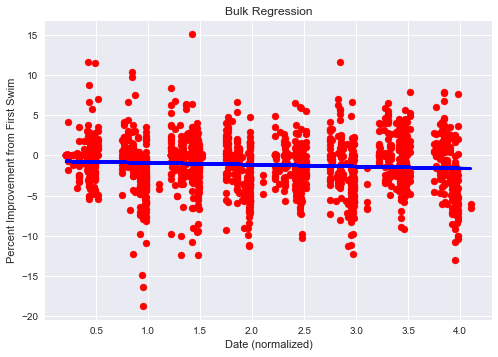

Coefficient of Linear Regression for the Male Group:  [-0.44007101]


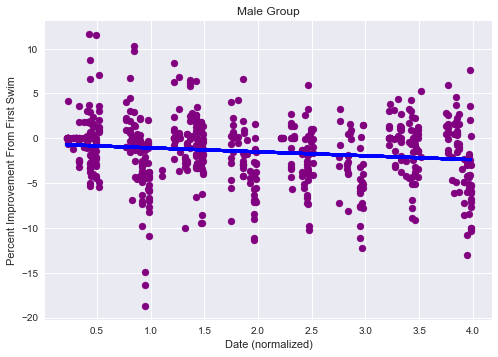

Coefficient of Linear Regression for the Male Season Bests:  [-0.26799608]


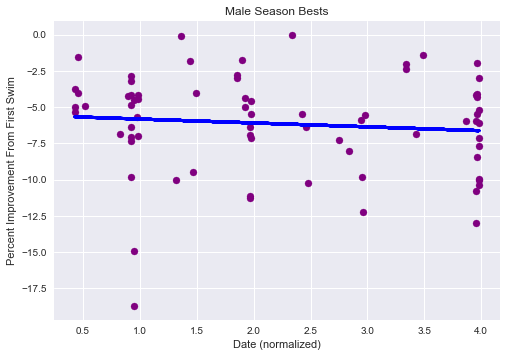

Coefficient of Linear Regression for the Female Group:  [-0.10663278]


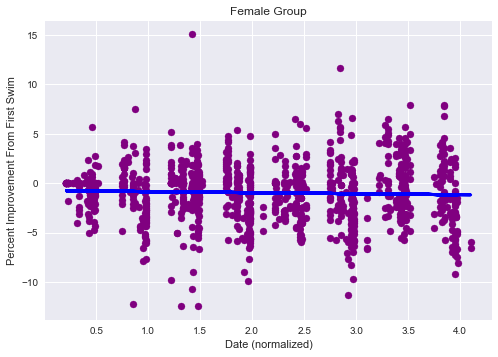

Coefficient of Linear Regression for the Female Season Bests:  [-0.34694234]


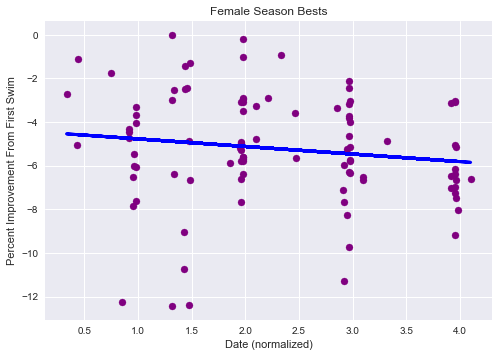

Coefficient of Linear Regression for the Sprint Group:  [-0.22018364]


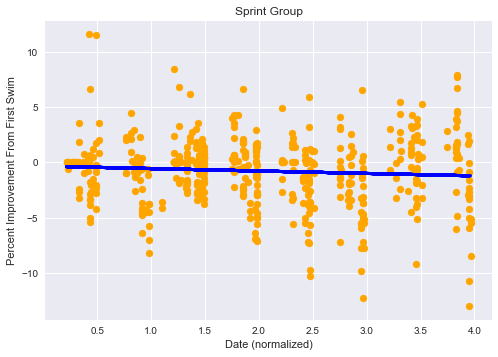

Coefficient of Linear Regression for the Sprint Season Bests:  [-0.80983628]


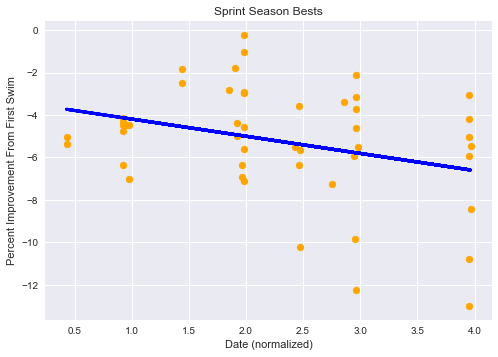

Coefficient of Linear Regression for the Mid Distance Group:  [-0.06727014]


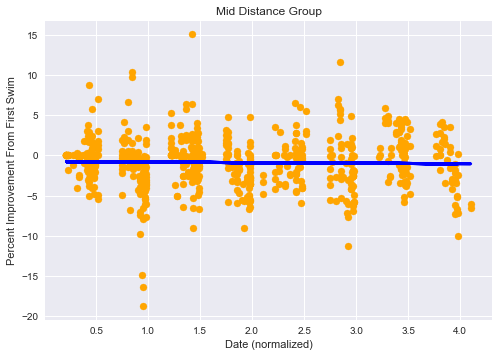

Coefficient of Linear Regression for the Mid Distance Season Bests:  [-0.28088773]


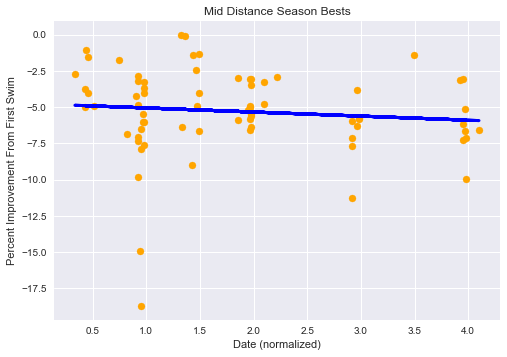

Coefficient of Linear Regression for the Distance Group:  [-0.17666642]


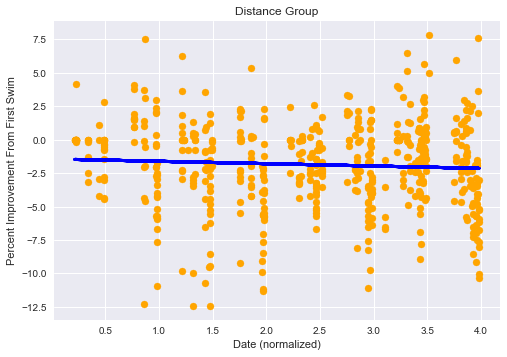

Coefficient of Linear Regression for the Distance Season Bests:  [ 0.65763983]


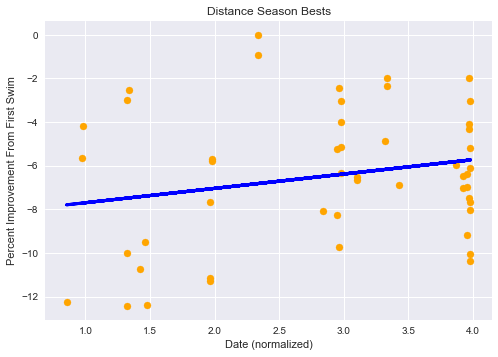

The following table shows the average time drop in seconds per event by men and women.

         Event       Male     Female
0      50 Free  -1.431538  -1.458750
1     100 Free  -4.570833  -2.190667
2     200 Free  -6.191667  -6.255833
3     500 Free -18.143333 -16.582857
4    1650 Free -82.660000 -34.760000
5     100 Back  -2.321429  -3.448333
6     200 Back  -5.767500  -7.722000
7   100 Breast  -3.550000  -3.980000
8   200 Breast  -8.830000  -9.335714
9      100 Fly  -5.335000  -3.086667
10     200 Fly -10.622500  -7.360000
11      200 IM  -5.306667  -6.521250
12      400 IM  -7.880000 -11.876667

Coefficient of Linear Regression for the 50 Free Group:  [-0.06954386]


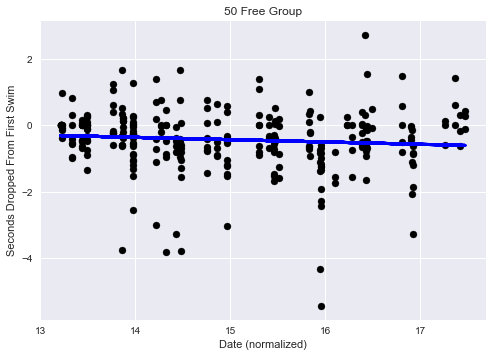

Coefficient of Linear Regression for the 50 Free Season Bests:  [ 0.01886878]


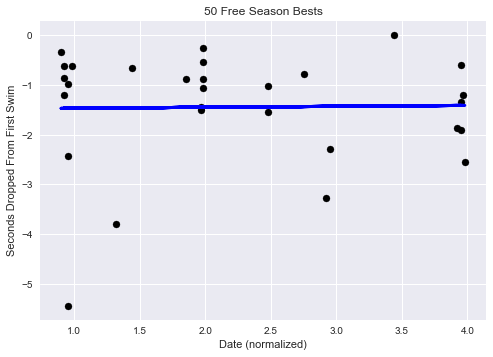

Coefficient of Linear Regression for the 100 Free Group:  [-0.12947665]


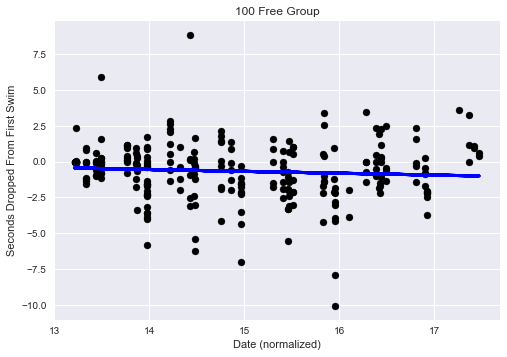

Coefficient of Linear Regression for the 100 Free Season Bests:  [-0.39809973]


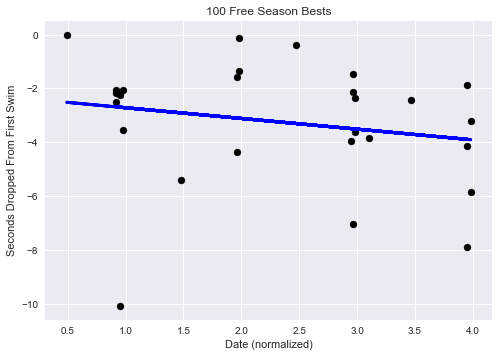

Coefficient of Linear Regression for the 200 Free Group:  [-0.37560899]


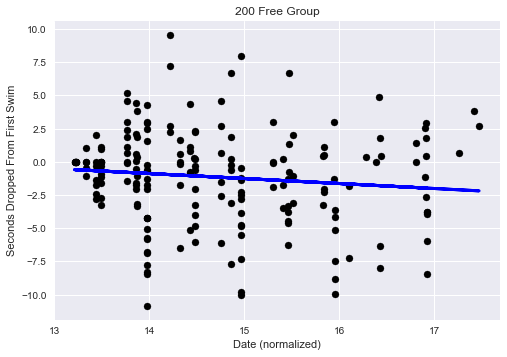

Coefficient of Linear Regression for the 200 Free Season Bests:  [-0.7515176]


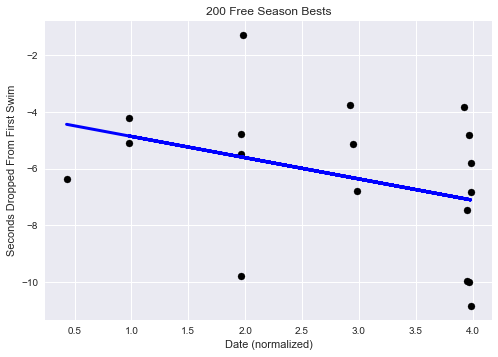

Coefficient of Linear Regression for the 500 Free Group:  [-3.26073491]


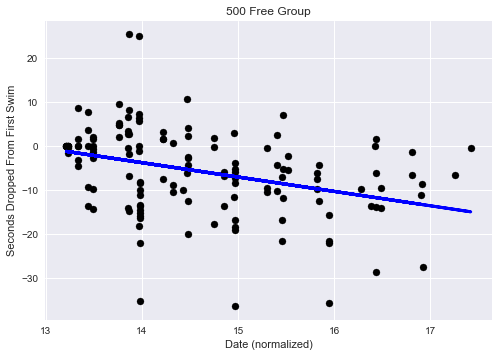

Coefficient of Linear Regression for the 500 Free Season Bests:  [-0.29396076]


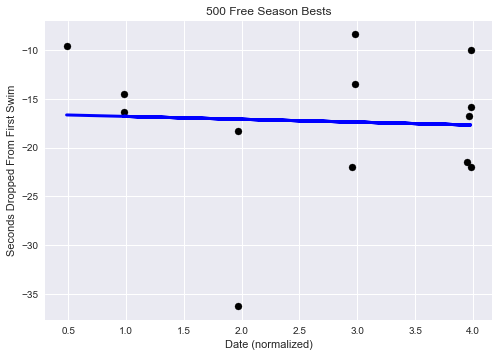

Coefficient of Linear Regression for the 1650 Free Group:  [-13.67271088]


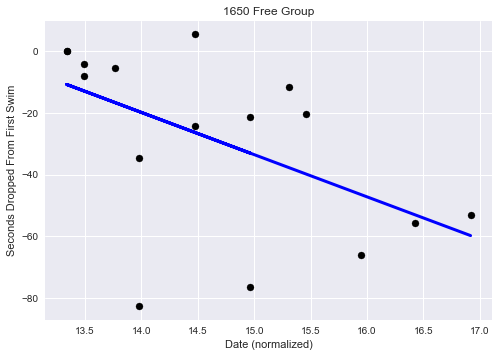

Coefficient of Linear Regression for the 1650 Free Season Bests:  [ 23.95]


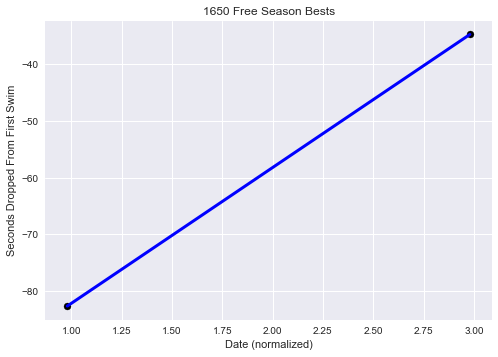

Coefficient of Linear Regression for the 100 Back Group:  [-0.10327317]


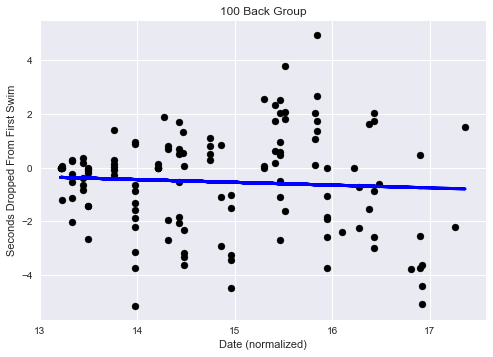

Coefficient of Linear Regression for the 100 Back Season Bests:  [ 0.45639855]


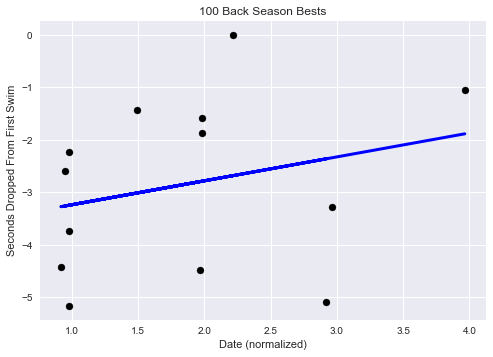

Coefficient of Linear Regression for the 200 Back Group:  [ 0.52536057]


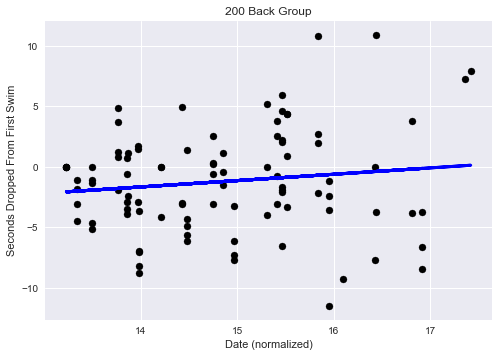

Coefficient of Linear Regression for the 200 Back Season Bests:  [-2.6864324]


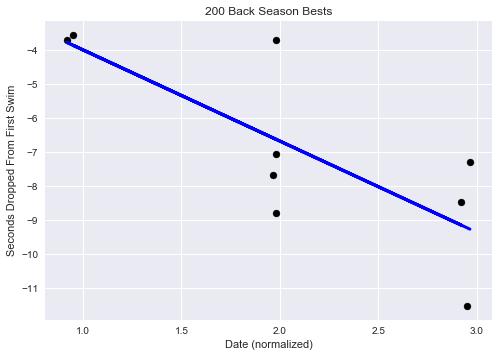

Coefficient of Linear Regression for the 100 Breast Group:  [-0.18884399]


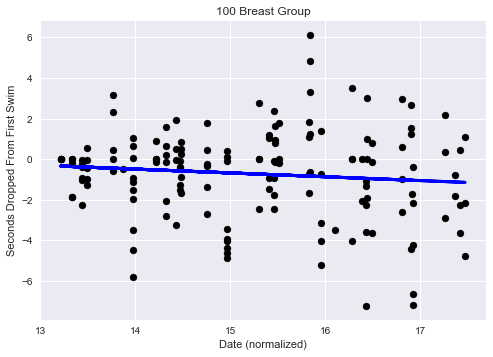

Coefficient of Linear Regression for the 100 Breast Season Bests:  [-0.41443185]


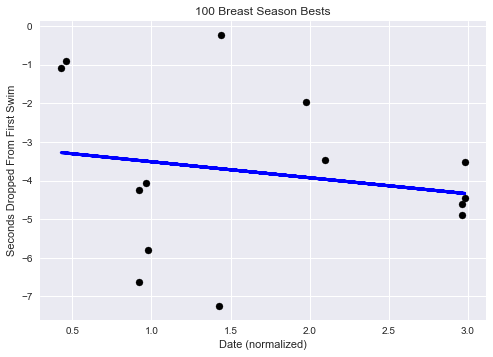

Coefficient of Linear Regression for the 200 Breast Group:  [ 0.23171336]


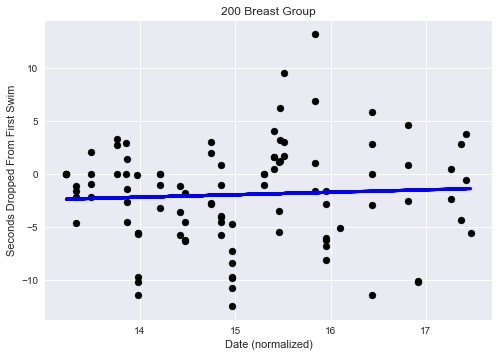

Coefficient of Linear Regression for the 200 Breast Season Bests:  [-0.67186944]


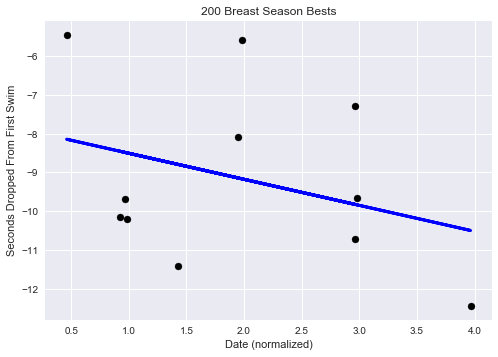

Coefficient of Linear Regression for the 100 Fly Group:  [ 0.05433047]


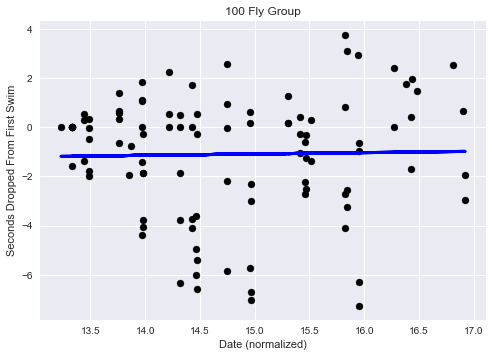

Coefficient of Linear Regression for the 100 Fly Season Bests:  [-1.19968061]


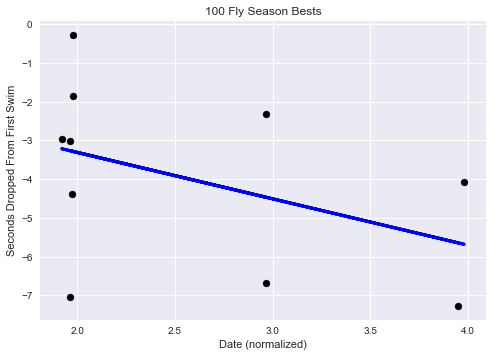

Coefficient of Linear Regression for the 200 Fly Group:  [-0.46510969]


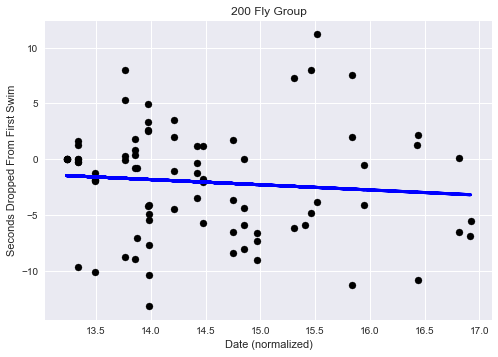

Coefficient of Linear Regression for the 200 Fly Season Bests:  [-1.55924438]


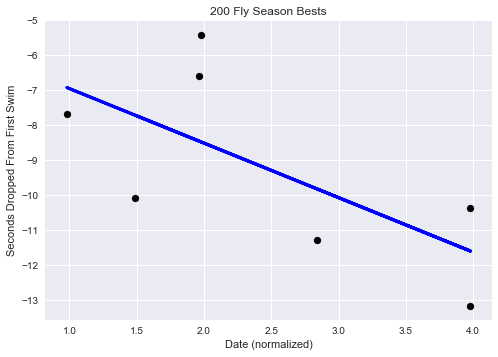

Coefficient of Linear Regression for the 200 IM Group:  [ 0.78974305]


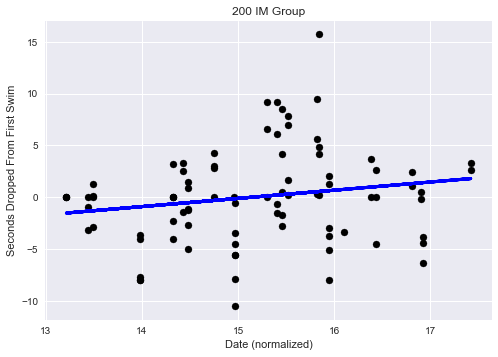

Coefficient of Linear Regression for the 200 IM Season Bests:  [-1.1855295]


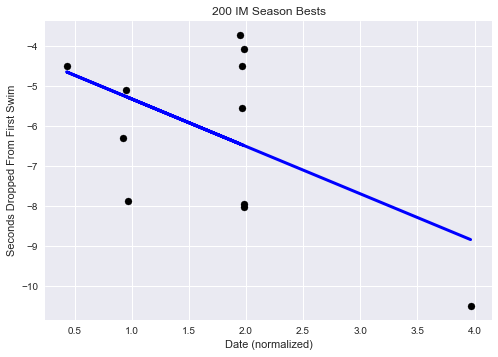

Coefficient of Linear Regression for the 400 IM Group:  [-0.0431337]


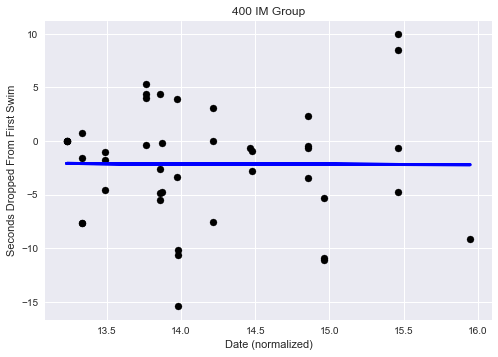

Coefficient of Linear Regression for the 400 IM Season Bests:  [-0.85890734]


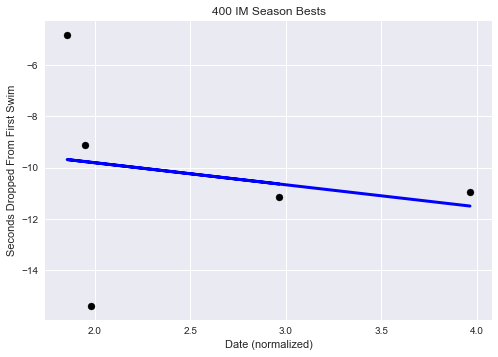


Now, within one year, how do people improve? Note: This is still relative to their first swim on record.

Coefficient of Linear Regression for the Year 1:  [-3.48024813]


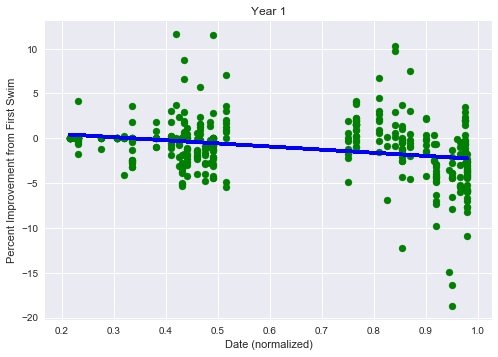

Coefficient of Linear Regression for the Year 2:  [-2.81354041]


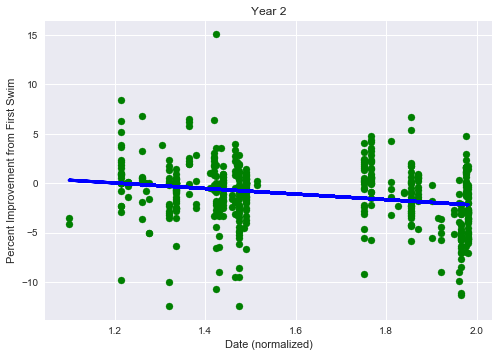

Coefficient of Linear Regression for the Year 3:  [-2.08822267]


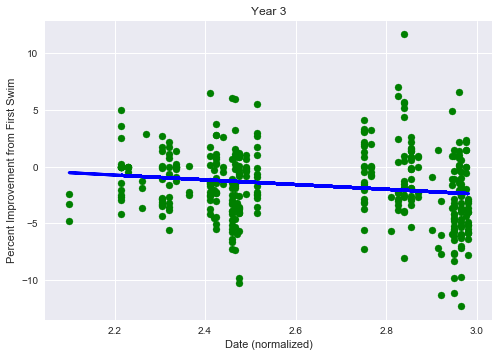

Coefficient of Linear Regression for the Year 4:  [-3.76824438]


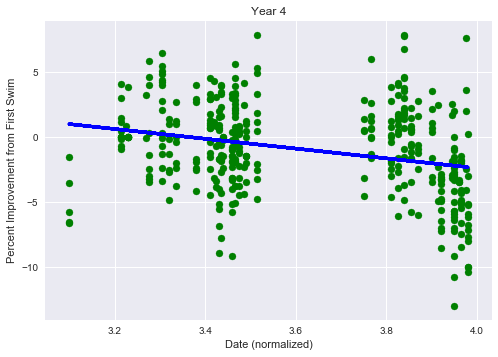


Now, we will look at the season bests by each year.

Coefficient of Linear Regression for the Comparing Season Bests Across Years:  [-0.29648632]


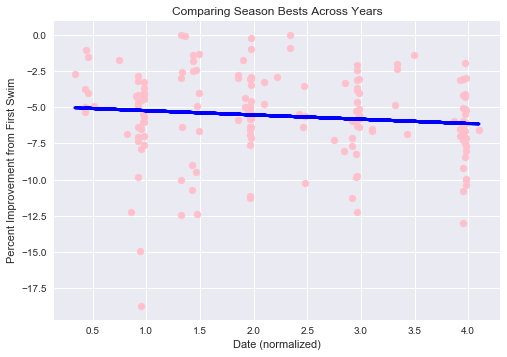

In [9]:
####Graphing in Python
#Goal is to do this in R in webapp

#Bulk analysis
X = []
y = []
for entry in swimdf.values:
    X.append([entry[3]])
    y.append(entry[5])
reg = linear_model.LinearRegression()
reg.fit(X,y)
predicted_outcome = reg.predict(X)
# Plot outputs
plotter(X,y,"Bulk Regression",'red',predicted_outcome,reg.coef_)

def scatplot(group, dfmarker, color, label,df1=swimdf):
    for item in group:
        X = []
        y = []
        #in season times
        for entry in df1.values:
            if entry[dfmarker] == item:
                X.append([entry[3]])
                y.append(entry[5])
            
        reg.fit(X,y)
        predicted_outcome = reg.predict(X)
        plotter(X,y,item+" Group",color,predicted_outcome,reg.coef_, ylabel=label)
        #season bests
        X.clear()
        y.clear()
        for entry in df1.values:
            if entry[dfmarker] == item:
                if entry[6] == True:
                    X.append([entry[3]])
                    y.append(entry[5])
            
        reg.fit(X,y)
        predicted_outcome = reg.predict(X)
        plotter(X,y,item+" Season Bests",color,predicted_outcome,reg.coef_,ylabel=label)
        
        
def scatplotraw(group, dfmarker, color, label,df1=swimdf, df2 = None):
    for item in group:
        X = []
        y = []
        #in season times
        for entry in df1.values:
            if entry[dfmarker] == item:
                X.append([entry[3]])
                y.append(entry[5])
            
        reg.fit(X,y)
        predicted_outcome = reg.predict(X)
        plotter(X,y,item+" Group",color,predicted_outcome,reg.coef_, ylabel=label)
        #season bests
        X.clear()
        y.clear()
        for entry in df2.values:
            if entry[dfmarker] == item:
                X.append([entry[3]])
                y.append(entry[5])
            
        reg.fit(X,y)
        predicted_outcome = reg.predict(X)
        plotter(X,y,item+" Season Bests",color,predicted_outcome,reg.coef_,ylabel=label)

#Comparison by Sex

sexes = ["Male","Female"]      
scatplot(sexes,1,"purple", label="Percent Improvement From First Swim")

training_groups = ["Sprint","Mid Distance", "Distance"]
scatplot(training_groups,2, "orange", label="Percent Improvement From First Swim")


print("The following table shows the average time drop in seconds per event by men and women.")
print()
lists = []
for event in event_list:
    average_drop_M= []
    average_drop_F = []
    for swimmer in swimmer_list:
        if swimmer.sex == "Male":
            if event in swimmer.top_4_events:
                time_drop = swimmer.raw_drop(event)
                if time_drop not in average_drop_M:
                    average_drop_M.append(time_drop)   
    for swimmer in swimmer_list:
        if swimmer.sex == "Female":
            if event in swimmer.top_4_events:
                time_drop = swimmer.raw_drop(event)
                if time_drop not in average_drop_F:
                    average_drop_F.append(time_drop)
    #print(average_drop_M)
    M_time = average(average_drop_M)
    F_time = average(average_drop_F)
    mfdrop = [event, M_time, F_time]
    lists.append(mfdrop)

event_drops = pd.DataFrame(lists)
event_drops.rows = event_list
event_drops.columns = ["Event","Male","Female"]
print(event_drops)
print()
scatplotraw(event_list,4,"black",label="Seconds Dropped From First Swim",df1=rawdropdf, df2=rdbestdf)


            ###Within one year analysis, how much do people improve within a single season?
print()
print("Now, within one year, how do people improve? Note: This is still relative to their first swim on record.")
print()
for i in range(0,4):
    X = []
    y = []
    #in season times
    for entry in swimdf.values:
        if int(entry[3]) == i:
            X.append([entry[3]])
            y.append(entry[5])               
    reg = linear_model.LinearRegression()
    reg.fit(X,y)
    predicted_outcome = reg.predict(X)
    # Plot outputs
    plotter(X,y,"Year {0}".format(i+1),'green',predicted_outcome,reg.coef_)
    
            ###Tracks by season best of each year
print()
print("Now, we will look at the season bests by each year.")
print()
X = []
y = []        
for entry in swimdf.values:
    if entry[6] == True:
        X.append([entry[3]])
        y.append(entry[5])  

reg = linear_model.LinearRegression()
reg.fit(X,y)
predicted_outcome = reg.predict(X)

# Plot outputs
plotter(X,y,"Comparing Season Bests Across Years", 'pink',predicted_outcome,reg.coef_)  


In [5]:
###Next Portion Does PCA and Feature reduction on the data
###This portion needs to be edited with each dataset, as the columns will change
### IT CURRENTLY WORKS PRAISE
x_prep = []
y_prep = []
data = []
for swimmer in swimmer_list:
    for event in event_list:
        if swimmer.recall_best_by_event_normalized(event) != 0:
            x_prep.append([swimmer.sex, swimmer.training_group, event])
            y_prep.append(swimmer.recall_best_by_event_normalized(event).time)
            data.append([swimmer.sex, swimmer.training_group, event, swimmer.recall_best_by_event_normalized(event).time])
X = np.array(x_prep)
y = np.array(y_prep)
data = np.array(data)

#scikit categorical to binarize
#2-d matrix where columns are features
#classification based off of threshold

sex = []
training_group = []
event = []
time_drop = y_prep

for item in X:
    sex.append(item[0])
    training_group.append(item[1])
    event.append(item[2])
    
cat = pd.DataFrame([sex, training_group, event, time_drop], ).T
cat.columns = ['Sex', 'Training Group','Event','Percent Time Drop']

cat

,Sex,Training Group,Event,Percent Time Drop
0,Male,Distance,200 Free,-4.32834
1,Male,Distance,500 Free,-1.9765
2,Male,Distance,100 Back,-0
3,Male,Distance,400 IM,-4.08896
4,Male,Distance,100 Free,-10.3576
5,Male,Distance,200 Free,-5.98442
6,Male,Distance,500 Free,-2.00071
7,Female,Mid Distance,100 Free,-5.75788
8,Female,Mid Distance,100 Breast,-5.16095
9,Female,Mid Distance,200 Breast,-6.65271


In [14]:
colnames = ['Percent Time Drop']
count = 1
for val in cat['Sex'].unique():
    cat['{0}'.format(val)] = cat['Sex'] == val
    colnames.append(val)
    count = count+1

for val in cat['Training Group'].unique():
    cat['{0}'.format(val)] = cat['Training Group'] == val
    colnames.append(val)
    count=count+1

for val in cat['Event'].unique():
    cat['{0}'.format(val)] = cat['Event'] == val
    colnames.append(val)
    count=count+1

print(len(colnames))
prep_list = []
for list1 in cat.values:
    list2 = []
    for i in range(3,len(colnames)+3):
        list2.append(list1[i])
    prep_list.append(np.array(list2))

#print(prep_list)
new_cat = pd.DataFrame(prep_list)
new_cat.columns = colnames


new_cat

19


,Percent Time Drop,Male,Female,Distance,Mid Distance,Sprint,200 Free,500 Free,100 Back,400 IM,100 Free,100 Breast,200 Breast,200 IM,50 Free,100 Fly,1650 Free,200 Fly,200 Back
0,-4.328345,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-1.976498,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.000000,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-4.088955,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-10.357649,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,-5.984419,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,-2.000708,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,-5.757883,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,-5.160954,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,-6.652714,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
            ###Feature analysis on new_cat

#print("Now that we have separated the data to see how each individual factor plays into improvement, we will examine them collectively to see which are the most important factors to cause improvement using Principle Component Analysis (PCA), Nonnegative Matrix Factorization (NMF), and Factor Analysis (FA).")

y = []
for list1 in new_cat.values:
    y.append(list1[0])

X = []
for list1 in new_cat.values:
    add_list = []
    for i in range(1,18):
        add_list.append(list1[i])
    X.append(add_list)

X = np.array(X)
y = np.array(y)


feature_selector = sk.feature_selection.mutual_info_regression(X,y)  ##This is the sparse matrix function
print("Now we will see how much we can attribute improvement to the different features.  This sum will not be 100%, as we have not accounted for every variable that applies to a swimmers improvement, such as training base, off season training, injury, practice attendance, etc.")
###feature_selector
print()
for i in range (len(feature_selector)):
    print("The ", end='')
    print(new_cat.columns[i+1], end='')
    print(" feature explains {0} Percent of the improvement shown.".format(feature_selector[i]*100))
    
print()
print("Sex accounts for {0}% of the improvement shown".format(feature_selector[0]*100+100*feature_selector[1]))
print("Training group accounts for {0}% of the improvement shown.".format(100*(feature_selector[2]+feature_selector[3]+feature_selector[4])))
event_weight = 0
for i in range(5,len(feature_selector)):
    event_weight = event_weight + feature_selector[i]*100
print("Event accounts for {0}% of the improvement shown".format(event_weight))

print()
print()
print("In summary, these swimmers have improved in a measurable way, yet this particular model is limited in how it explains improvement.  No model can explain 100% of the improvement, yet we can attribute discrete amounts to sex, training group, and event.")


Now we will see how much we can attribute improvement to the different features.  This sum will not be 100%, as we have not accounted for every variable that applies to a swimmers improvement, such as training base, off season training, injury, practice attendance, etc.

The Male feature explains 6.533201219413098 Percent of the improvement shown.
The Female feature explains 6.533201219413098 Percent of the improvement shown.
The Distance feature explains 0.0 Percent of the improvement shown.
The Mid Distance feature explains 2.8366983209482166 Percent of the improvement shown.
The Sprint feature explains 0.21225785597684954 Percent of the improvement shown.
The 200 Free feature explains 0.32291979366785295 Percent of the improvement shown.
The 500 Free feature explains 0.04106088080191306 Percent of the improvement shown.
The 100 Back feature explains 0.47976210893545534 Percent of the improvement shown.
The 400 IM feature explains 1.5002285075977895 Percent of the improvement shown.


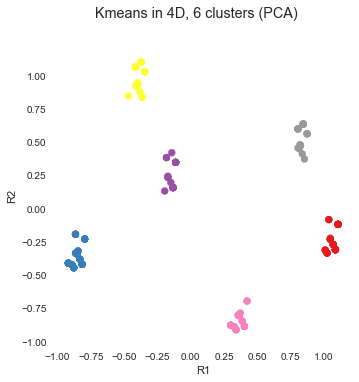

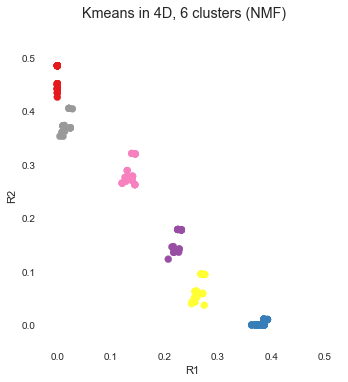

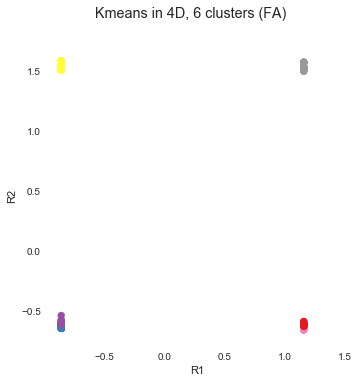

V measure 0.502779066635
Adj. Rand score -0.000140850860649




In [5]:
### Extra Stuff I'm not doing anything with currently

def scatterplot_2D(R, title, labels=None):
    """ Helper function to plot data points in 2D
        Requires (N, 2) numpy array shape
    """
    assert(R.shape[1] == 2)
    # class labels are turned into colors
    if labels is None:
        c = 'black'
    else:
        color_scale = np.linspace(0, 1, len(set(labels)))
        c = [plt.cm.Set1(color_scale[i]) for i in labels]

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.patch.set_facecolor('white')
    ax.scatter(R[...,0], R[...,1], color=c)
    ax.axis('square')
    ax.set_xlabel('R1')
    ax.set_ylabel('R2')
    fig.suptitle(title)
    plt.show()
    

# Clustering the original 7D dataset with KMeans
kmeans = sk.cluster.KMeans(n_clusters=6, random_state=0).fit(X)
R_PCA = sk.decomposition.PCA(n_components=2).fit_transform(X)
scatterplot_2D(R_PCA, 'Kmeans in 4D, 6 clusters (PCA)', kmeans.labels_)
X_nonnegative = sk.preprocessing.MinMaxScaler().fit_transform(X)
R_NMF = sk.decomposition.NMF(n_components=2).fit_transform(X_nonnegative)
scatterplot_2D(R_NMF, 'Kmeans in 4D, 6 clusters (NMF)', kmeans.labels_)
R = sk.decomposition.FactorAnalysis(n_components=2).fit_transform(X)
scatterplot_2D(R, 'Kmeans in 4D, 6 clusters (FA)', kmeans.labels_)
print("V measure", sk.metrics.cluster.v_measure_score(y, kmeans.labels_))
print("Adj. Rand score", sk.metrics.cluster.adjusted_rand_score(y, kmeans.labels_))
print()
print()